In [10]:
import lmfit
import numpy as np
import sympy
from sympy import symbols, I
import matplotlib.pyplot as plt
from math import pi
import cmath

def s11_complex(f, z, l0, l1, l2):
    return (z - 2*pi*sympy.I*(l0 + l1*f + l2*f**2))/(z + 2*pi*sympy.I*(l0 + l1*f + l2*f**2))

def conv(l):
    for i in range(len(l)):
        l[i] = complex(l[i])
    return l

def s11_simple(f, z, l0):
    return (z - 2*pi*f*l0)/(z + 2*pi*f*l0)

# sympy.pprint(s11(sympy.symbols('f')), use_unicode=False)

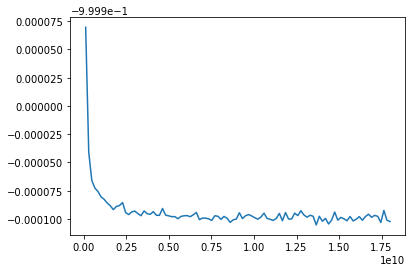

In [12]:
f = np.linspace(1e8, 18e9, 100)
s = s11_simple(f=f, z=50, l0=.000910) + 0.000003*np.random.randn(len(f))
plt.plot(f, s)
plt.show()
# print result.fit_report()

In [13]:
p = lmfit.Parameters()
p.add_many(('z', 50.), ('l0', .000910))

def residual(p):
    v = p.valuesdict()
    return (v['z']-2*pi*f*v['l0'])/(v['z'] + 2*pi*f*v['l0']) - s

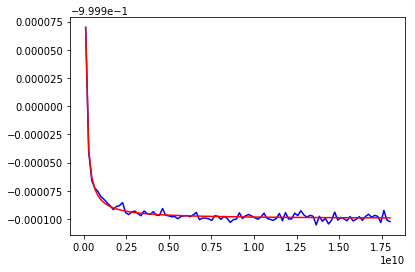

In [14]:
mi = lmfit.minimize(residual, p)
plt.plot(f, s, 'b')
plt.plot(f, residual(mi.params) + s, 'r')
plt.show()

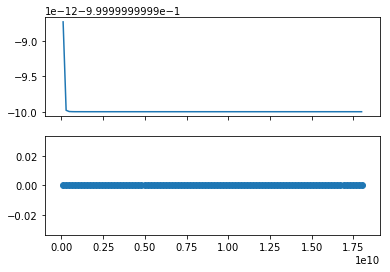

In [19]:
f = np.linspace(1e8, 18e9, 100)
s_noise = conv(s11_complex(f, 50, 1e-9, 1e-9, 1e-9))
r = [s_noise[i].real for i in range(len(s_noise))]
i = [s_noise[i].imag for i in range(len(s_noise))]

p, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(f, r)
axarr[1].scatter(f, i)
# plt.show()

In [22]:
# https://github.com/lmfit/lmfit-py/pull/316
# https://groups.google.com/forum/#!searchin/lmfit-py/complex$20data/lmfit-py/9b-svhK1lKg/n9mCDs49BgAJ


par = lmfit.Parameters()
par.add_many(('z', 50.), ('l0', 1e-9), ('l1', 1e-9), ('l2', 1e-9))

def calculate_complex_residual(p):
    v = p.valuesdict()
    return conv((v['z'] - 2*pi*I*(v['l0']+v['l1']*f+v['l2']*f**2))/(v['z'] + 2*pi*I*(v['l0']+v['l1']*f+v['l2']*f**2)) - s_noise)

# print [type(calculate_complex_residual(par)[i]) for i in range(len(calculate_complex_residual(par)))]

IndentationError: unexpected indent (<ipython-input-22-4be665c7df55>, line 8)

In [21]:
def residual(p):
    resid = calculate_complex_residual(p)
    return resid.view(np.complex)
    
# mini = lmfit.minimize(residual, par)

# r = [imag_to_float(residual(par))[i].real for i in range(len(imag_to_float(residual(par))))]
# i = [imag_to_float(residual(par))[i].imag for i in range(len(imag_to_float(residual(par))))]
# mod_real = lmfit.minimize(r, p)
# mod_imag = lmfit.minimize(i, p)

# p, axarr = plt.subplots(2, sharex=True)
# axarr[0].plot(f, r, 'b')
# axarr[0].plot(f, (residual(mini.params) + s).real, 'r')
# axarr[1].plot(f, i, 'b')
# axarr[1].plot(f, (residual(mini.params) + s).imag, 'r')
# plt.show()

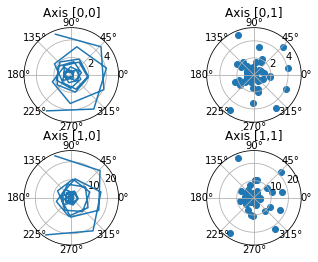

In [37]:
# Four polar axes
p, axarr = plt.subplots(2, 2, subplot_kw=dict(projection='polar'))
axarr[0, 0].plot(x, y)
axarr[0, 0].set_title('Axis [0,0]')
axarr[0, 1].scatter(x, y)
axarr[0, 1].set_title('Axis [0,1]')
axarr[1, 0].plot(x, y ** 2)
axarr[1, 0].set_title('Axis [1,0]')
axarr[1, 1].scatter(x, y ** 2)
axarr[1, 1].set_title('Axis [1,1]')

# Fine-tune figure; make subplots farther from each other.
p.subplots_adjust(hspace=0.3)
plt.show()

# Complex Fits?

In [26]:
def linear_resonator(f, f_0, Q, Q_e_real, Q_e_imag):
    Q_e = Q_e_real + 1j*Q_e_imag
    return (1 - (Q * Q_e**-1 /
                     (1 + 2j * Q * (f - f_0) / f_0)))

dict().pop('verbose',None)

class ResonatorModel(lmfit.model.Model):
    __doc__ = "resonator model" + lmfit.models.COMMON_DOC
    def __init__(self, *args, **kwargs):
        # pass in the defining equation so the user doesn't have to later.
        super(ResonatorModel, self).__init__(linear_resonator, *args, **kwargs)
        
        self.set_param_hint('Q', min = 0)  # Enforce Q is positive
    
    def guess(self, data, f=None, **kwargs):
        verbose = kwargs.pop('verbose',None)
        if f is None:
            return
        argmin_s21 = np.abs(data).argmin()
        fmin = f.min()
        fmax = f.max()
        f_0_guess = f[argmin_s21] # guess that the resonance is the lowest point
        Q_min = 0.1 * (f_0_guess/(fmax-fmin)) # assume the user isn't trying to fit just a small part of a resonance curve.
        delta_f = np.diff(f) #assume f is sorted
        min_delta_f = delta_f[delta_f>0].min()
        Q_max = f_0_guess/min_delta_f # assume data actually samples the resonance reasonably
        Q_guess = np.sqrt(Q_min*Q_max) # geometric mean, why not?
        Q_e_real_guess = Q_guess/(1-np.abs(data[argmin_s21]))
        if verbose:
            print "fmin=",fmin,"fmax=",fmax,"f_0_guess=",f_0_guess
            print "Qmin=",Q_min,"Q_max=",Q_max,"Q_guess=",Q_guess,"Q_e_real_guess=",Q_e_real_guess
        params = self.make_params(Q=Q_guess, Q_e_real=Q_e_real_guess, Q_e_imag=0, f_0=f_0_guess)
        params['%sQ' % self.prefix].set(min=Q_min, max=Q_max)
        params['%sf_0' % self.prefix].set(min=fmin, max=fmax)
        return lmfit.models.update_param_vals(params,self.prefix,**kwargs)

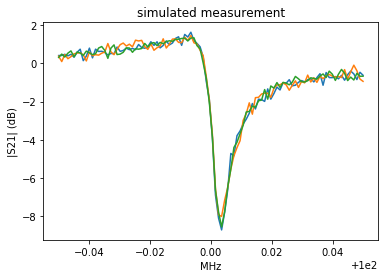

In [31]:
resonator = ResonatorModel()
true_params=resonator.make_params(f_0=100,Q=10000,Q_e_real=9000,Q_e_imag=-9000)
f = np.linspace(99.95,100.05,100)
true_s21 = resonator.eval(params=true_params,f=f)
noise_scale = 0.02
measured_s21 = true_s21 + noise_scale*(np.random.randn(100) + 1j*np.random.randn(100))

plt.plot(f,20*np.log10(np.abs(measured_s21)))
plt.ylabel('|S21| (dB)')
plt.xlabel('MHz')
plt.title('simulated measurement')

plt.show()

In [34]:
guess = resonator.guess(measured_s21, f=f, verbose=True)
result = resonator.fit(measured_s21, params=guess, f=f, verbose=True)
print result.fit_report()

fmin= 99.95 fmax= 100.05 f_0_guess= 100.003535354
Qmin= 100.003535354 Q_max= 99003.5000006 Q_guess= 3146.53778182 Q_e_real_guess= 5021.32168197
[[Model]]
    Model(linear_resonator)
[[Fit Statistics]]
    # function evals   = 38
    # data points      = 200
    # variables        = 4
    chi-square         = 0.068
    reduced chi-square = 0.000
    Akaike info crit   = -1590.422
    Bayesian info crit = -1577.228
[[Variables]]
    f_0:        99.9999811 +/- 6.47e-05 (0.00%) (init= 100.0035)
    Q:          9992.64128 +/- 124.2343 (1.24%) (init= 3146.538)
    Q_e_real:   9064.64352 +/- 115.6981 (1.28%) (init= 5021.322)
    Q_e_imag:  -8955.82291 +/- 115.6922 (1.29%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(Q, Q_e_real)               =  0.520 
    C(f_0, Q_e_imag)             =  0.519 
    C(f_0, Q_e_real)             =  0.513 
    C(Q, Q_e_imag)               = -0.513 



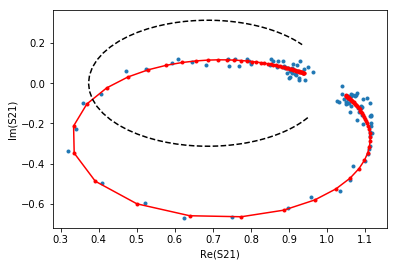

In [41]:
def plot_ri(data, *args, **kwargs):
    plt.plot(data.real, data.imag, *args, **kwargs)
    
fit_s21 = resonator.eval(params=result.params, f=f)
guess_s21 = resonator.eval(params=guess, f=f)

plot_ri(measured_s21,'.')
plot_ri(fit_s21,'r.-')
plot_ri(guess_s21,'k--')
plt.xlabel('Re(S21)')
plt.ylabel('Im(S21)')
plt.show()

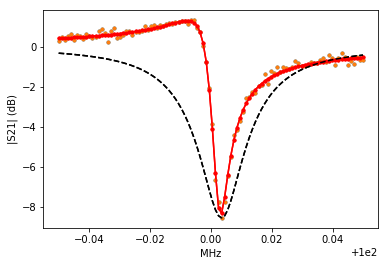

In [43]:
plt.plot(f,20*np.log10(np.abs(measured_s21)),'.')
plt.plot(f,20*np.log10(np.abs(fit_s21)),'r.-')
plt.plot(f,20*np.log10(np.abs(guess_s21)),'k--')
plt.ylabel('|S21| (dB)')
plt.xlabel('MHz')
plt.show()